In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

## Calculated PSF from PROPER

In [2]:
from spirals import binarized_ringed_flipped

def binarized_ringed_650(r, phi):
    phase = 650.*1e-9*0.5
    return binarized_ringed_flipped(r, phi, phase)
beam_ratio = 0.4
toliman_settings = {
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 571.7300 / 1000.,
                    'm1_m2_sep': 549.240/1000.,
                    'm2_fl': -23.3800/1000.,
                    'bfl': 590.000 / 1000., 
                    'm2_rad': 5.9 / 1000., 
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': beam_ratio,
                    'tilt_x': 0.00,
                    'tilt_y': 0.00,
                    'phase_func': binarized_ringed_650,
                    'm1_hole_rad':0.025,
                    'use_caching':True
                    }

gridsize = 2048 # sampling of wavefront
wavelength = 0.65 # micros
# First source, on axis
source = {
            'wavelengths': [wavelength],
            'weights': [1.],
            'settings': toliman_settings
            }


In [3]:
import proper
detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

# Calculated PSF
from proper_tools import form_detector_image
raw_image = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)


/suphys/bjef8061/.local/lib/python3.5/site-packages/pyfits-3.5-py3.5-linux-x86_64.egg/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


Couldn't load file binarized_ringed_650_2048_0.00036621093749999995.npy


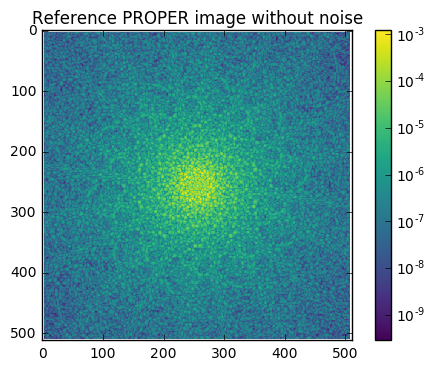

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.imshow(raw_image, interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.title('Reference PROPER image without noise')
plt.show()

## Add Poisson noise

Scale image to have a peak of 25k to be below saturation, then add photon noise by drawing random values from a Poisson distribution.

In [5]:
intensity_scale = (25000/raw_image.max(axis=None))
detector_image = np.random.poisson(
    intensity_scale*np.clip(raw_image,0.,1.)
)
print(np.sum((detector_image - intensity_scale*raw_image)**2))

18972679.474


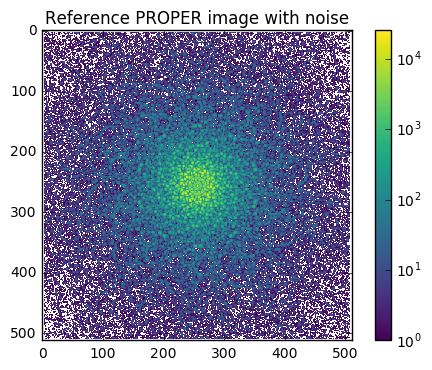

In [6]:
plt.imshow(detector_image, interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.title('Reference PROPER image with noise')
plt.show()

## Fit by tweaking telescope magnification

Let's assume that the model is correct, and that the only parameter that isn't well known is the spacing between the primary and secondary mirrors. Assume also that both the reference and model PSFs are at their corresponding focal planes. Optimise the model to minimise the error between the two detector images.

In [7]:
# Adapted from Barnaby's code for the lens equation 

#Fa = 0.5 * 1.143451
#Fb = -0.5 * 0.0467579189727913
#T = 0.549337630333726
def bfl(fa, fb, d):
    '''Calculate back focal length for a pair of lenses
    
    Parameters
    ----------
    fa: float
    primary lens focal length
    
    fb: float
    secondary lens focal length, in same units as fa
    
    d: float
    separation between primary and secondary lenses, in same units as fa and fb

    Returns
    -------
    Distance from secondary lens to focal plane
    '''
    # 1/f = 1/fa + 1/fb - d/(fa fb)
    f = (1./fa + 1./fb - d/(fa * fb))**-1
    # Assume thin lenses so BFL = F(Fa - T) / Fa
    return f*(fa - d) / fa

In [8]:
# Function to generate 
def model_err(sep):
    print('Trying with separation ', sep)
    settings = toliman_settings.copy()
    fa = settings['m1_fl']
    fb = settings['m2_fl']
    settings['m1_m2_sep'] = sep 
    b = bfl(fa, fb, sep)
    settings['bfl'] = b
    print('Calculated BFL ', b)
    source = {
            'wavelengths': [wavelength],
            'weights': [1.],
            'settings': settings
            }
    im = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)
    # Normalize values
    intensity_scale = 25000/detector_image.max(axis=None)
    im *= intensity_scale
    error = np.sum((im - detector_image)**2)
    print('Error ', error)
    return error

In [9]:
from scipy.optimize import least_squares
sep_error = 0.01
sep_init = toliman_settings['m1_m2_sep']+sep_error
opt = least_squares(model_err, sep_init)

Trying with separation  [ 0.55924]
Calculated BFL  [ 0.02681508]
Error  69631617965.6
Trying with separation  [ 0.55924001]
Calculated BFL  [ 0.02681501]
Error  69631617965.5
Trying with separation  [ 1.11848]
Calculated BFL  [-0.02242123]
Error  69631627339.0
Trying with separation  [ 0.69905]
Calculated BFL  [-0.01975276]
Error  69631627310.9
Trying with separation  [ 0.5941925]
Calculated BFL  [-0.01145603]
Error  69631573095.9
Trying with separation  [ 0.59419251]
Calculated BFL  [-0.01145604]
Error  69631573096.1
Trying with separation  [ 0.55924]
Calculated BFL  [ 0.02681508]
Error  69631617965.6
Trying with separation  [ 0.58545438]
Calculated BFL  [-0.00864793]
Error  69631585185.8
Trying with separation  [ 0.59200797]
Calculated BFL  [-0.01085939]
Error  69631575320.0
Trying with separation  [ 0.59364637]
Calculated BFL  [-0.01131227]
Error  69631573067.8
Trying with separation  [ 0.59364638]
Calculated BFL  [-0.01131227]
Error  69631573067.8
Trying with separation  [ 0.593509

In [10]:
# How do things look now?
settings = toliman_settings.copy()
fa = settings['m1_fl']
fb = settings['m2_fl']
sep = opt.x[0]
print("Optimal separation {} differs from target by {}".format(sep, sep-sep_init))
settings['m1_m2_sep'] = sep 
b = bfl(fa, fb, sep)
settings['bfl'] = b
source = {
    'wavelengths': [wavelength],
    'weights': [1.],
        'settings': settings
    }
final = form_detector_image('prescription_rc_quad', [source], gridsize, detector_pitch, npixels)

Optimal separation 0.5935098339843751 differs from target by 0.034269833984375


In [11]:
final *= 25000/final.max(axis=None)

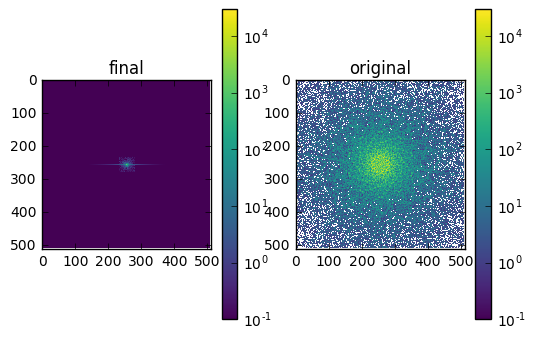

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2)
im=axes[0].imshow(final, interpolation = 'none', cmap='viridis',aspect='equal', norm=LogNorm() ,vmin=1e-1, vmax=30000)
axes[0].set_title('final')
plt.colorbar(im, ax=axes[0])
im=axes[1].imshow(detector_image, interpolation = 'none', cmap='viridis',aspect='equal',norm=LogNorm(),vmin=1e-1, vmax=30000)
axes[1].set_title('original')
plt.colorbar(im, ax=axes[1])
plt.show()

In [13]:
print(np.sum((detector_image - final)**2))

69050703416.8


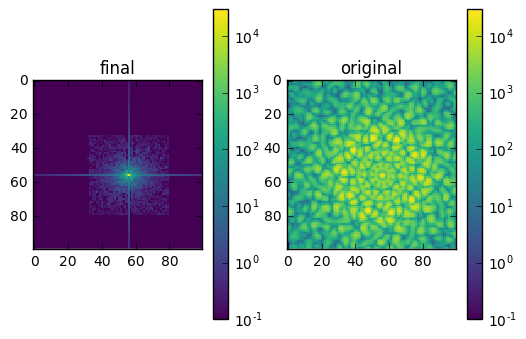

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2)
im=axes[0].imshow(final[200:300,200:300], interpolation = 'none', cmap='viridis',aspect='equal', norm=LogNorm() ,vmin=1e-1, vmax=30000)
axes[0].set_title('final')
plt.colorbar(im, ax=axes[0])
im=axes[1].imshow(detector_image[200:300,200:300], interpolation = 'none', cmap='viridis',aspect='equal',norm=LogNorm(),vmin=1e-1, vmax=30000)
axes[1].set_title('original')
plt.colorbar(im, ax=axes[1])
plt.show()